<a href="https://colab.research.google.com/github/LeonardoSer/Univ/blob/main/NetOpt/jupyter_notebooks/MST-all-2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Minimum Spanning Tree Problem 
## Complete Subtour Elimination Constraints (SEC) formulation  

This formulation contains all SEC inequalities.
See slides **Network Optimization Part III.pdf** for details


In [1]:
!python -m pip install -i https://pypi.gurobi.com gurobipy
!sudo apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt


from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display



Looking in indexes: https://pypi.gurobi.com
     |████████████████████████████████| 11.1MB 7.6MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bi

In [ ]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

class args:
    filename = None
    scale = 40
    figsize = (6,6)

## Drawing functions

In [ ]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()

### Decision variables:

$$
x_{ij} = \begin{cases} 1 \text{ if edge } e=\{i,j\} \text{ is selected} \\
0 \text{ otherwise.}\end{cases}
$$

### Formulation

$$
\min \sum_{e=\{i,j\} \in E} c_{ij} x_{ij} \\
\sum_{e=\{i,j\} \in E} x_{ij} = |V| - 1 \\
\sum_{e=\{i,j\} \in E(S)} x_{ij} \le |S| - 1, \;\; \forall S \subset V, 2 < |S| \le |V| - 1  \\
x \le 1 \\ 
x \ge 0
$$

In [ ]:
args.filename = "graph.gml"
args.scale = 20
args.figsize = (10,10)

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 45 edges


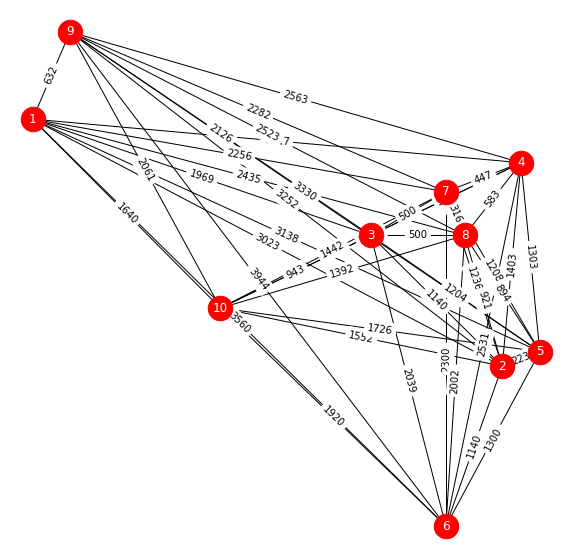

In [ ]:
DrawInitG(G, withedges=True)

In [ ]:
G.edges()

EdgeView([(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 7), (6, 8), (6, 9), (6, 10), (7, 8), (7, 9), (7, 10), (8, 9), (8, 10), (9, 10)])

In [ ]:
mst = gb.Model()

# Decision Variables

x = mst.addVars(G.edges(), 
                obj=[G[u][v]['cost'] for u,v in G.edges()],
                ub = 1.0,
                vtype=gb.GRB.CONTINUOUS,
                name='x')

mst.update()

x

Academic license - for non-commercial use only - expires 2021-05-15
Using license file /Users/fabrizio/Solvers/licenses/gurobi.lic


{(1, 2): <gurobi.Var x[1,2]>,
 (1, 3): <gurobi.Var x[1,3]>,
 (1, 4): <gurobi.Var x[1,4]>,
 (1, 5): <gurobi.Var x[1,5]>,
 (1, 6): <gurobi.Var x[1,6]>,
 (1, 7): <gurobi.Var x[1,7]>,
 (1, 8): <gurobi.Var x[1,8]>,
 (1, 9): <gurobi.Var x[1,9]>,
 (1, 10): <gurobi.Var x[1,10]>,
 (2, 3): <gurobi.Var x[2,3]>,
 (2, 4): <gurobi.Var x[2,4]>,
 (2, 5): <gurobi.Var x[2,5]>,
 (2, 6): <gurobi.Var x[2,6]>,
 (2, 7): <gurobi.Var x[2,7]>,
 (2, 8): <gurobi.Var x[2,8]>,
 (2, 9): <gurobi.Var x[2,9]>,
 (2, 10): <gurobi.Var x[2,10]>,
 (3, 4): <gurobi.Var x[3,4]>,
 (3, 5): <gurobi.Var x[3,5]>,
 (3, 6): <gurobi.Var x[3,6]>,
 (3, 7): <gurobi.Var x[3,7]>,
 (3, 8): <gurobi.Var x[3,8]>,
 (3, 9): <gurobi.Var x[3,9]>,
 (3, 10): <gurobi.Var x[3,10]>,
 (4, 5): <gurobi.Var x[4,5]>,
 (4, 6): <gurobi.Var x[4,6]>,
 (4, 7): <gurobi.Var x[4,7]>,
 (4, 8): <gurobi.Var x[4,8]>,
 (4, 9): <gurobi.Var x[4,9]>,
 (4, 10): <gurobi.Var x[4,10]>,
 (5, 6): <gurobi.Var x[5,6]>,
 (5, 7): <gurobi.Var x[5,7]>,
 (5, 8): <gurobi.Var x[5,8]>,
 (

In [ ]:
mst.write('mst.lp')

In [ ]:
# Cardinality constraint

mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mst.update()

mst.write('mst.lp')

## Subtour elimination constraints: complete enumeration

In [ ]:
len(list(powerset(G.nodes())))

1024

In [ ]:
sec = 0

for i in powerset(G.nodes()):
    if len(i) > 2 and len(i) <= G.number_of_nodes() - 1:
        sec += 1
        S = G.subgraph(i)
        if S.number_of_edges() > S.number_of_nodes() - 1:
            
            # Add only edges existing in S 
            # NOTE 
            # a variable key error may arise without  
            # the conditional statement (edges are undirected)
            # 

                
            mst.addConstr(gb.quicksum(x[i,j] \
                                      if (i,j) in x else x[j,i] \
                                      for i,j in S.edges()) \
                          <= S.number_of_nodes() - 1, 'Sec' + str(sec))
            
            
mst.update()
mst.write('mst.lp')

print ("Number of Subtour Elimination Constraints:", sec)


Number of Subtour Elimination Constraints: 967


In [ ]:
mst.optimize()

x

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 968 rows, 45 columns and 11475 nonzeros
Model fingerprint: 0x211b7527
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 9e+00]
Presolve time: 0.01s
Presolved: 968 rows, 45 columns, 11475 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0070000e+03   1.024000e+03   0.000000e+00      0s
       8    6.7350000e+03   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.01 seconds
Optimal objective  6.735000000e+03


{(1, 2): <gurobi.Var x[1,2] (value 0.0)>,
 (1, 3): <gurobi.Var x[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var x[1,4] (value 0.0)>,
 (1, 5): <gurobi.Var x[1,5] (value 0.0)>,
 (1, 6): <gurobi.Var x[1,6] (value 0.0)>,
 (1, 7): <gurobi.Var x[1,7] (value 0.0)>,
 (1, 8): <gurobi.Var x[1,8] (value 0.0)>,
 (1, 9): <gurobi.Var x[1,9] (value 1.0)>,
 (1, 10): <gurobi.Var x[1,10] (value 1.0)>,
 (2, 3): <gurobi.Var x[2,3] (value 0.0)>,
 (2, 4): <gurobi.Var x[2,4] (value 0.0)>,
 (2, 5): <gurobi.Var x[2,5] (value 1.0)>,
 (2, 6): <gurobi.Var x[2,6] (value 1.0)>,
 (2, 7): <gurobi.Var x[2,7] (value 0.0)>,
 (2, 8): <gurobi.Var x[2,8] (value 0.0)>,
 (2, 9): <gurobi.Var x[2,9] (value 0.0)>,
 (2, 10): <gurobi.Var x[2,10] (value 0.0)>,
 (3, 4): <gurobi.Var x[3,4] (value 0.0)>,
 (3, 5): <gurobi.Var x[3,5] (value 0.0)>,
 (3, 6): <gurobi.Var x[3,6] (value 0.0)>,
 (3, 7): <gurobi.Var x[3,7] (value 0.0)>,
 (3, 8): <gurobi.Var x[3,8] (value 1.0)>,
 (3, 9): <gurobi.Var x[3,9] (value 0.0)>,
 (3, 10): <gurobi.Var x[3,10] 

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 968 rows, 45 columns and 11475 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 9e+00]

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.735000000e+03
Optimal solution: 6735.0


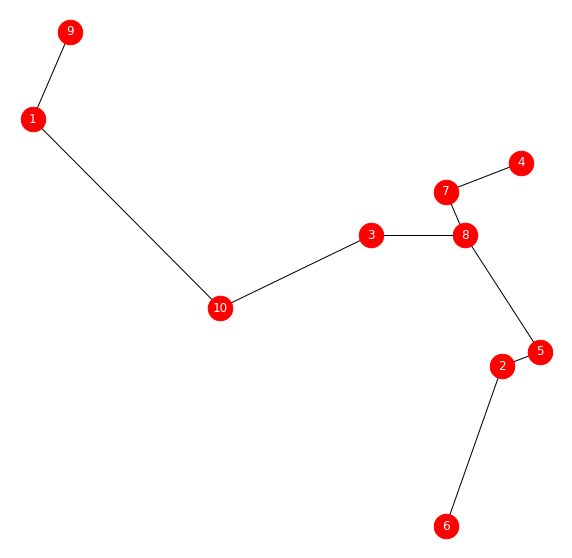

In [ ]:

mst.optimize()

print ("Optimal solution:", mst.objVal)
DrawSol(G,x)


### @HOME:

1. Generate a graph with a ``networkx`` graph generator up 20 nodes
2. Generate an instance of the MST with the ``random`` module, generating random positive costs
3. Calculate the MST with the formulation above and with the ``networkx`` method

## Subtour Elimination Constraints: a cutting plane example

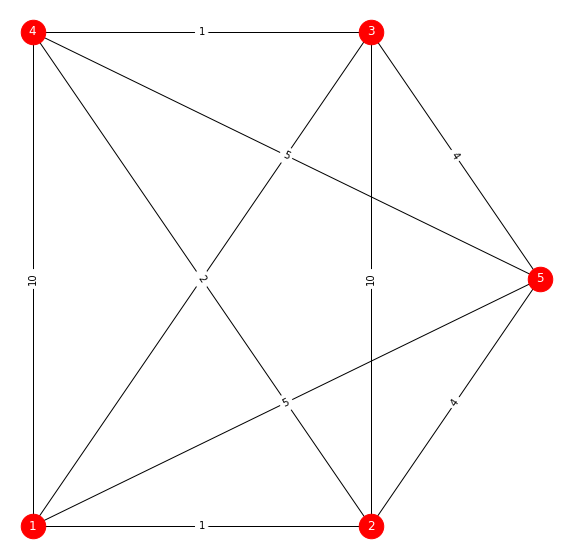

In [ ]:
G = nx.Graph()

G.add_nodes_from([1,2,3,4,5])

G.nodes[1]['x'] = 0
G.nodes[1]['y'] = 0

G.nodes[2]['x'] = 10
G.nodes[2]['y'] = 0

G.nodes[3]['x'] = 10
G.nodes[3]['y'] = 10

G.nodes[4]['x'] = 0
G.nodes[4]['y'] = 10

G.nodes[5]['x'] = 15
G.nodes[5]['y'] = 5

G.add_edge(1,2, cost=1)
G.add_edge(1,3, cost=2)
G.add_edge(1,4, cost=10)
G.add_edge(1,5, cost=5)

G.add_edge(2,3, cost=10)
G.add_edge(2,4, cost=2)
G.add_edge(2,5, cost=4)

G.add_edge(3,4, cost=1)
G.add_edge(3,5, cost=4)

G.add_edge(4,5, cost=5)


DrawInitG(G,True)


In [ ]:
mst = gb.Model()

# Decision Variables

x = mst.addVars(G.edges(), \
                obj=[G[u][v]['cost'] for u,v in G.edges()],\
                ub = 1.0,\
                vtype=gb.GRB.CONTINUOUS,\
                name='x')

mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mst.update()

mst.write('mst.lp')

In [ ]:
mst.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0xb78b6ec2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Presolve removed 0 rows and 5 columns
Presolve time: 0.01s
Presolved: 1 rows, 5 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+00   2.000000e+00   0.000000e+00      0s
       1    6.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  6.000000000e+00


In [ ]:
x[1,2].x

1.0

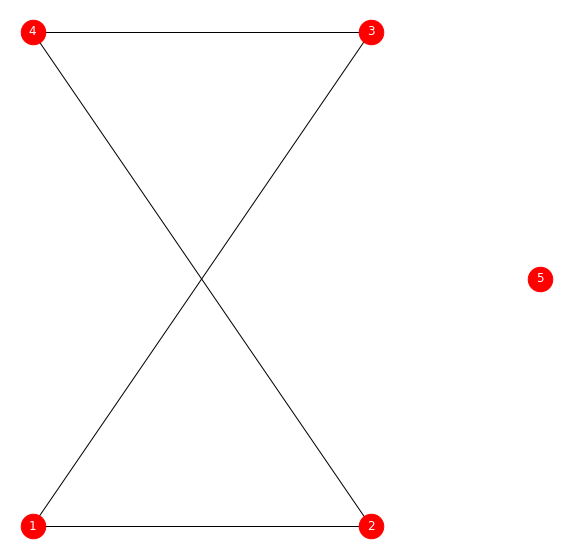

In [ ]:
DrawSol(G,x)

The solution does not represent a tree and there exists a violated subtour inequality.
Namely:

$$S=\{1, 2, 3, 4\}$$

$$x_{1,2} + x_{1,3} + x_{1,4} + x_{2,3} + x_{2,4} + x_{3,4} \le 3 $$

is violated by the solution above

In [ ]:
mst.addConstr(x[1,2] + x[1,3] + x[1,4] + x[2,3] + x[2,4]\
              + x[3,4] <= 3)

<gurobi.Constr *Awaiting Model Update*>

In [ ]:
mst.write('mst.lp')

In [ ]:
mst.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 10 columns and 16 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 4e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0000000e+00   1.000000e+00   0.000000e+00      0s
       1    8.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  8.000000000e+00


In [ ]:
x

{(1, 2): <gurobi.Var x[1,2] (value 1.0)>,
 (1, 3): <gurobi.Var x[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var x[1,4] (value 0.0)>,
 (1, 5): <gurobi.Var x[1,5] (value 0.0)>,
 (2, 3): <gurobi.Var x[2,3] (value 0.0)>,
 (2, 4): <gurobi.Var x[2,4] (value 1.0)>,
 (2, 5): <gurobi.Var x[2,5] (value 1.0)>,
 (3, 4): <gurobi.Var x[3,4] (value 1.0)>,
 (3, 5): <gurobi.Var x[3,5] (value 0.0)>,
 (4, 5): <gurobi.Var x[4,5] (value 0.0)>}

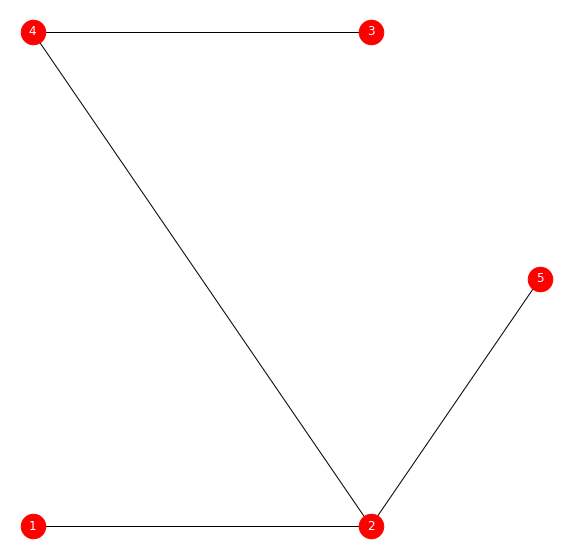

In [ ]:
DrawSol(G,x)

## Subtour Elimination Constraints formulation (SEC): separation problem

### Problem formulation

$$
\max \sum_{e=\{i,j\} \in E} x^*_e w_{ij} - \sum_{j \in V} z_j \\
w_{ij} - z_i \le 0  \;\;\; \forall \{i,j\} \in E\\
w_{ij} - z_j \le 0 \;\;\; \forall \{i,j\} \in E\\
z_k = 1\\
0 \le z \le 1, 0 \le w \le 1
$$

In [ ]:
#
# Subtour Elimination Constraints: separation
# 

def SECseparation (x, G, kappa):
    
    #
    # Definition of the separation problem
    #
    
    SECsep = gb.Model()
    
    #
    # Variables w_ij and z_i
    #
    
    w = SECsep.addVars(G.edges(), 
                       obj=[x[u,v].x for u,v in G.edges()],
                       ub = 1.0,
                       vtype=gb.GRB.CONTINUOUS, name='w')
        
    z = SECsep.addVars(G.nodes(),
                       obj = -1.0,
                       ub = 1.0,
                       vtype=gb.GRB.CONTINUOUS, name='z')

    #
    # Objective function
    #

    SECsep.ModelSense = -1
    
    #
    # Constraints
    #

    SECsep.addConstrs((w[i,j] - z[i] <= 0 \
                       for i,j in G.edges()), name = 'WZ1')
    
    SECsep.addConstrs((w[i,j] - z[j] <= 0 \
                       for i,j in G.edges()), name = 'WZ2')
    
    SECsep.addConstr(z[kappa] == 1, name="Fixing")
    
    SECsep.update()
    
    SECsep.write('sep.lp')

    SECsep.optimize()

    if (SECsep.objVal) > -1.0:
        SEC = [i for i in G.nodes() if z[i].x > 0.1]
        return True, SEC
    else:
        return False, None


In [ ]:
args.filename = "graph.gml"
args.scale = 20
args.figsize = (10,10)

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 45 edges


## Master problem 

The master problem now contains only the cardinality constraint


In [ ]:
mst = gb.Model()

# Decision Variables

x = mst.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()], ub = 1.0,\
                vtype=gb.GRB.CONTINUOUS, name='x')

# Cardinality constraint

mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mst.update()

mst.write('mst.lp')

In [ ]:
mst.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 45 columns and 45 nonzeros
Model fingerprint: 0x649b46a6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 9e+00]
Presolve removed 0 rows and 3 columns
Presolve time: 0.01s
Presolved: 1 rows, 42 columns, 42 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0070000e+03   8.000000e+00   0.000000e+00      0s
       1    5.0160000e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.016000000e+03


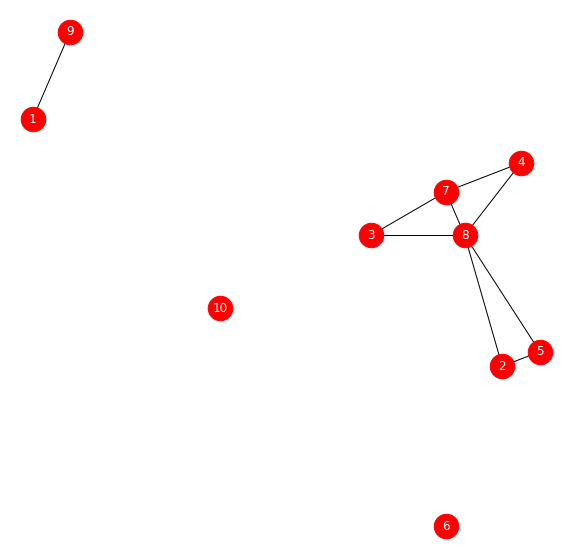

In [ ]:
DrawSol(G,x)

## Cutting plane algorithm

Now the cutting plane algorithm. 

At each iteration, after the resolution of the master LP (note, the relaxation) 
a sequence of separation problems are solved
and if there exists a violated SEC then it is added to the master. 

The cutting plane is interactive, thus press ``Enter`` key to continue.

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 45 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 9e+00]

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.016000000e+03
Current solution value: 5016.0


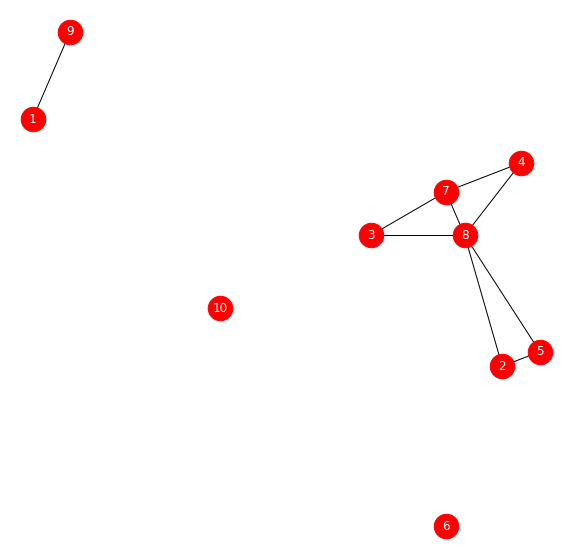

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x86dbcd32
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 75 rows and 41 columns
Presolve time: 0.01s
Presolved: 16 rows, 14 columns, 32 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   4.000000e+00   0.000000e+00      0s
       6    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.02 seconds
Optimal objective  1.000000000e+00
Found violated subtour. S = [1, 2, 3, 4, 5, 7, 8]
<gurobi.LinExpr: x[1,2] + x[1,3] + x[1,4] + x[1,5] + x[1,7] + x[1,8] + x[2,3] + x[2,4] + x[2,5] + x[2,7] + x[2,8] + x[3,4] + x[3,5] + x[3,7] + x[3,8] + x[4,5] + x[4,7] + x[4,8] + x[5,7] + x[5,8] +

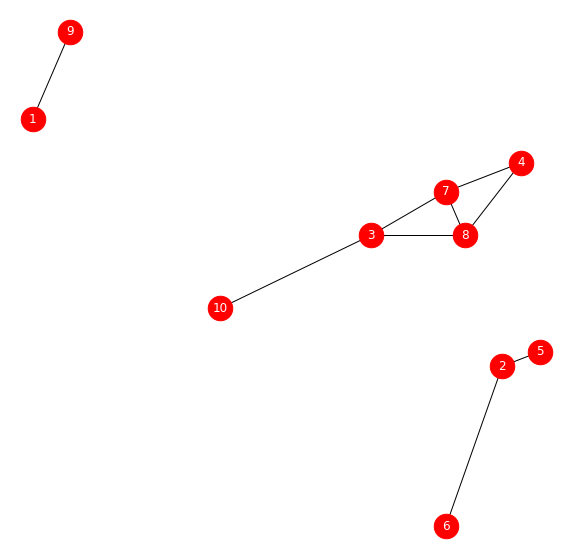

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x056c81fc
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 81 rows and 46 columns
Presolve time: 0.00s
Presolved: 10 rows, 9 columns, 20 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
       4   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Found violated subtour. S = [1, 3, 4, 7, 8]
<gurobi.LinExpr: x[1,3] + x[1,4] + x[1,7] + x[1,8] + x[3,4] + x[3,7] + x[3,8] + x[4,7] + x[4,8] + x[7,8]>
Press Enter to continue...

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 

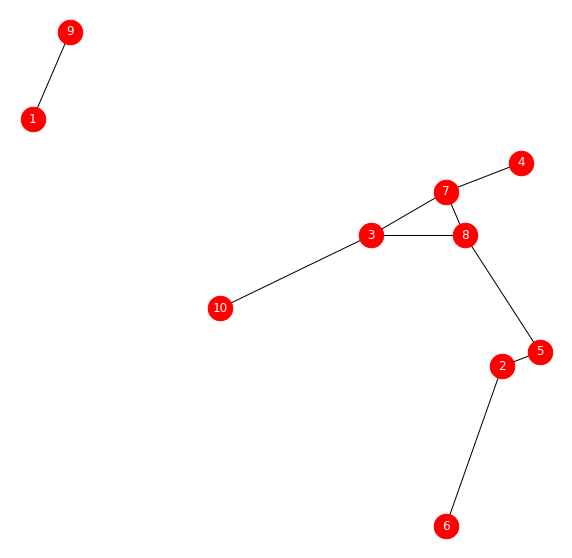

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x1e8fc4e6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.00s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x76ad4d81
Coefficient statistics:
  Ma

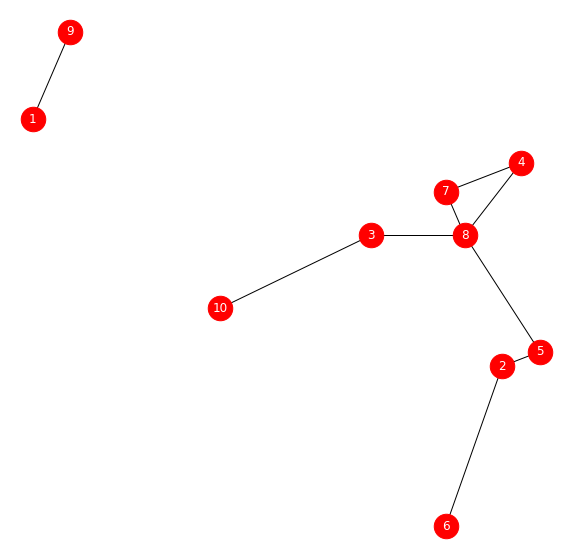

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x2082a7bf
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x7e149c06
Coefficient statistics:
  Ma

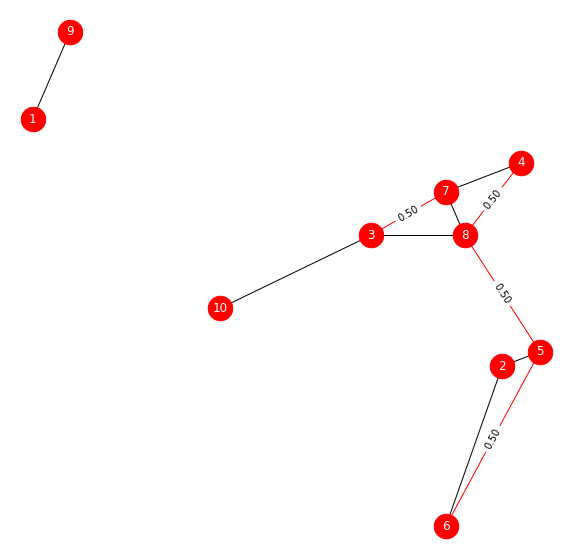

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x7f20ce48
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 73 rows and 39 columns
Presolve time: 0.00s
Presolved: 18 rows, 16 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x0e96fd2b
Coefficient statistics:
  

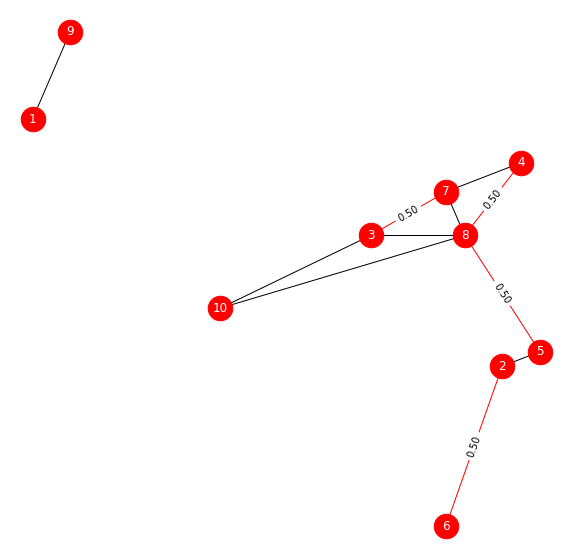

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0xdf8e49de
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 77 rows and 43 columns
Presolve time: 0.00s
Presolved: 14 rows, 12 columns, 28 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   4.000000e+00   0.000000e+00      0s
Extra simplex iterations after uncrush: 2
       6   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Found violated subtour. S = [1, 3, 4, 7, 8, 10]
<gurobi.LinExpr: x[1,3] + x[1,4] + x[1,7] + x[1,8] + x[1,10] + x[3,4] + x[3,7] + x[3,8] + x[3,10] + x[4,7] + x[4,8] + x[4,10] + x[7,8] + x[7,10] + x[8,10]>


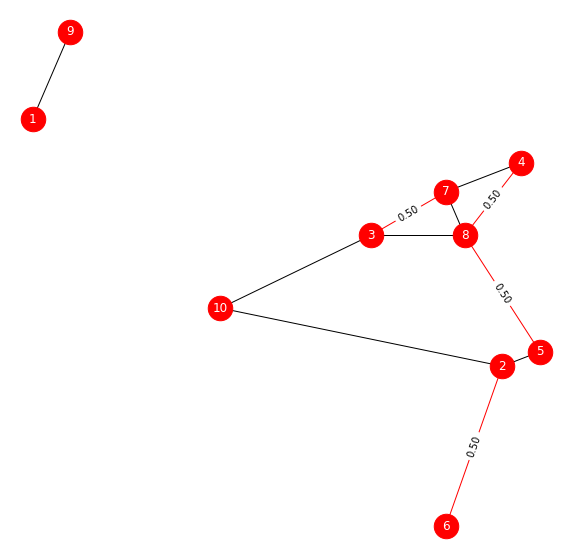

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x72a7cd95
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 73 rows and 39 columns
Presolve time: 0.00s
Presolved: 18 rows, 16 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
       7   -5.0000000e-01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds
Optimal objective -5.000000000e-01
Found violated subtour. S = [1, 2, 3, 4, 5, 7, 8, 10]
<gurobi.LinExpr: x[1,2] + x[1,3] + x[1,4] + x[1,5] + x[1,7] + x[1,8] + x[1,10] + x[2,3] + x[2,4] + x[2,5] + x[2,7] + x[2,8] + x[2,10] + x[3,4] + x[3,5

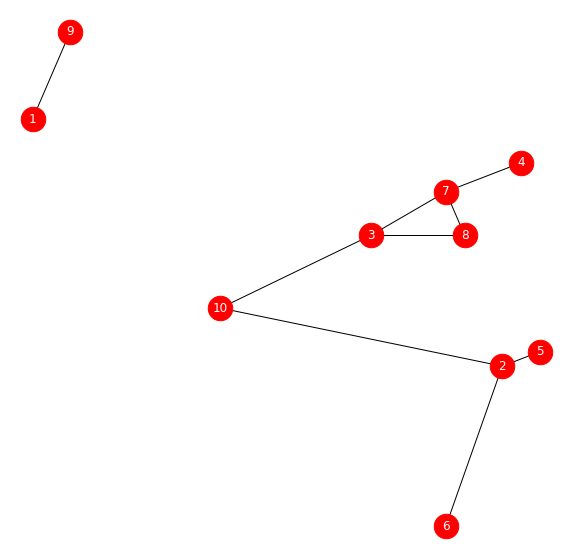

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0xd7ca3930
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.00s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x1c890ca7
Coefficient statistics:
  Ma

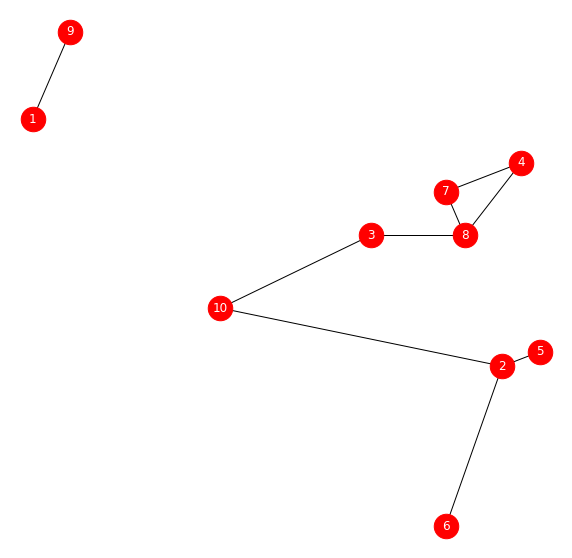

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x918c0666
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.00s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x86545975
Coefficient statistics:
  Ma

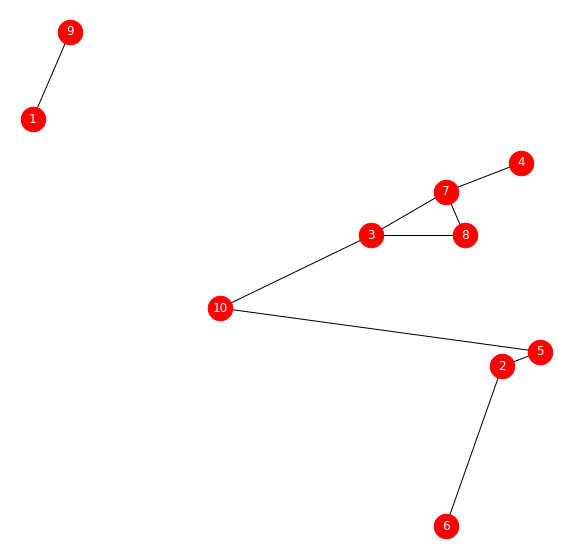

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0xa0ae4ed2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.00s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x8e0732c3
Coefficient statistics:
  Ma

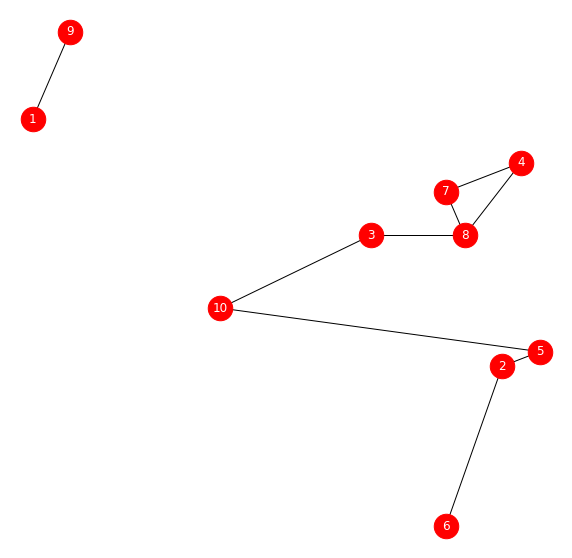

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x1040c00e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.00s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x9b8f70da
Coefficient statistics:
  Ma

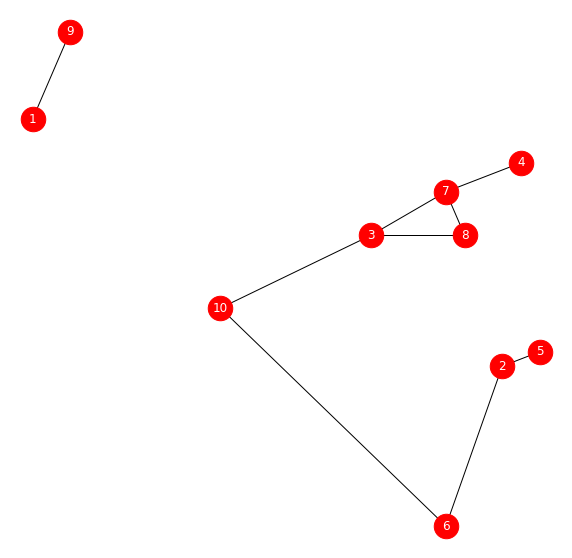

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x832fd410
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.00s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0xe71ffc60
Coefficient statistics:
  Ma

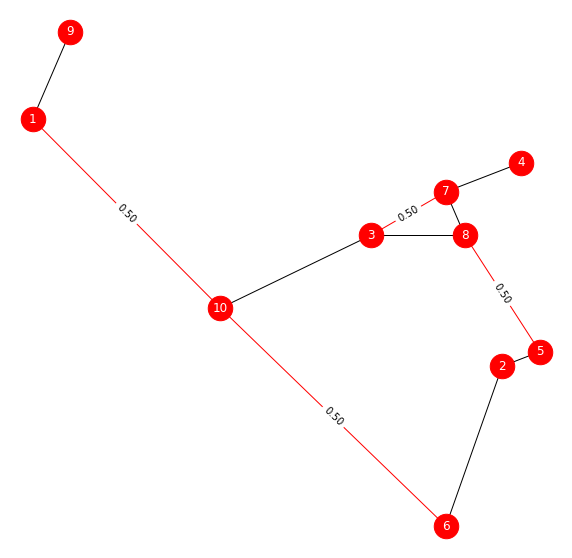

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0xc1165ab9
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 75 rows and 40 columns
Presolve time: 0.00s
Presolved: 16 rows, 15 columns, 32 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
       5   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0xd86eee4b
Coefficient statistics:
  

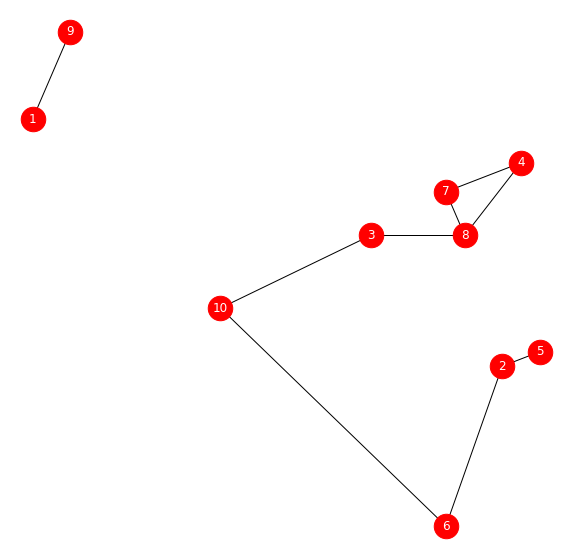

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0xba7c6c8a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 85 rows and 49 columns
Presolve time: 0.00s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x723c1272
Coefficient statistics:
  Ma

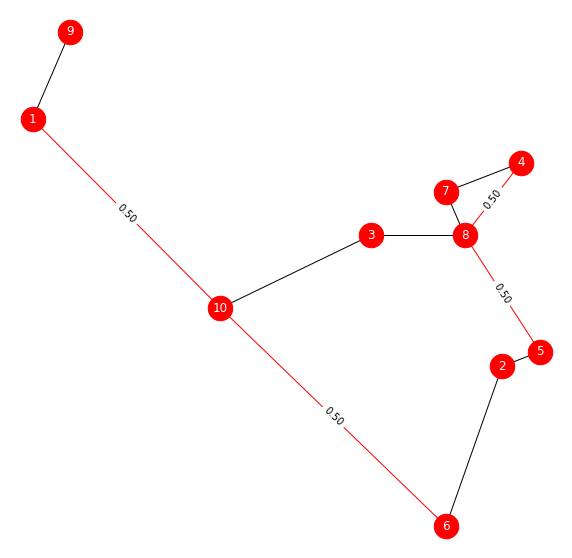

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0xbeff0a52
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 73 rows and 38 columns
Presolve time: 0.00s
Presolved: 18 rows, 17 columns, 36 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   2.000000e+00   0.000000e+00      0s
       5   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x213fffaa
Coefficient statistics:
  

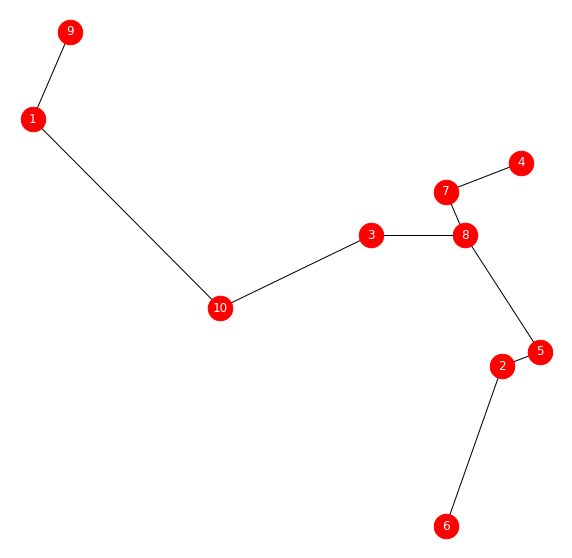

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0x5214c337
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 91 rows and 55 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -1.000000000e+00
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91 rows, 55 columns and 181 nonzeros
Model fingerprint: 0xb828dd5c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bo

In [ ]:


cont = True
#ftime = True

#
# Main cutting plane algorithm
#

sec = 1

while cont: 
    
    # Master optimization
    
    mst.optimize()
    print ("Current solution value:", mst.objVal)

    DrawSol(G,x)

    cont = False
    for u in G.nodes():
        status, S = SECseparation(x, G, u)
        if status:
            cont = True
            SEC = G.subgraph(S)
            
            print ("Found violated subtour. S =", SEC.nodes())
            
            print(gb.quicksum(x[i,j] \
                                      if (i,j) in G.edges() else x[j,i] \
                                      for i,j in SEC.edges()))

            #
            # Constraint is added: 
            # variable key error may arise without  
            # the conditional statement (edges are undirected)
            # 

            mst.addConstr(gb.quicksum(x[i,j] \
                                      if (i,j) in G.edges() else x[j,i] \
                                      for i,j in SEC.edges()) \
                                      <= SEC.number_of_nodes() - 1, 'Sec' + str(sec))
        
            
            sec += 1
            
            mst.write('mstsep.lp')
            input("Press Enter to continue...\n")       
            break

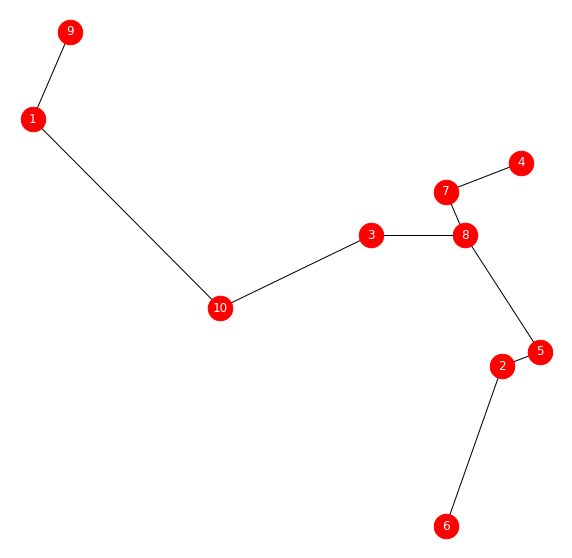

In [ ]:
DrawSol(G,x)

## Single commodity flow formulation

$$
x_e = \begin{cases}
1 \text{ if edge $e$ is in the tree} \\
0 \text { otherwise}
\end{cases}
$$

Associate to each edge $e$ two directed arcs $(i,j)$ and $(j,i)$ and let 

$$
f_{ij} = \{\text{flow carried by the arc} (i,j)\}
$$

\begin{alignat}{3}
\min cx &&\\
\sum_{e \in E} x_e = n - 1 && \\
\sum_{j \in \delta^+(0)} f_{0j} - \sum_{j \in \delta^-(0)} f_{j0} = n - 1 &&\\
\sum_{j \in \delta^-(v)} f_{jv} - \sum_{j \in \delta^+(v)} f_{vj} = 1 &&\;\; \forall v \in V, v \not = \{0\} \\
f_{ij} \le (n-1)x_e &&\;\; \forall e \in E, e=\{i,j\}\\
f_{ji} \le (n-1)x_e &&\;\; \forall e \in E, e=\{i,j\}\\
f \ge 0, \; x_e \in \{0,1\}
\end{alignat}

In [ ]:
def DrawSolFlow (G,x,f):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos,  
                           node_shape='o', 
                           node_size=600,
                           node_color='r', 
                           label=[G.nodes()])
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           nodelist = [root], 
                           node_shape='o',
                           node_size=600,
                           node_color='k', 
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w')
    
    for h,k in G.edges():
        
        flow = abs(f[h,k].x - f[k,h].x)
        
        

        G[h][k]['capacity'] = x[h,k].x
        if x[h,k].x > 0.00001:
            if x[h,k].x > 0.999999:
                nx.draw_networkx_edges(G, 
                                       pos=pos, 
                                       edgelist=[(h,k)],
                                       edge_color='k')
                
                nx.draw_networkx_edge_labels(G, 
                                             pos=pos,
                                             edge_labels={(h,k):'{:.2f}'.format(flow)})
            else:
                nx.draw_networkx_edges(G, 
                                       pos=pos, 
                                       edgelist=[(h,k)],
                                       edge_color='r')

    plt.axis('off')
    plt.show()

In [ ]:
args.filename = "graph.gml"
args.scale = 40

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 10 nodes and 45 edges


In [ ]:
G.nodes(data=True)

NodeDataView({1: {'y': 33, 'x': 1}, 2: {'y': 16, 'x': 26}, 3: {'y': 25, 'x': 19}, 4: {'y': 30, 'x': 27}, 5: {'y': 17, 'x': 28}, 6: {'y': 5, 'x': 23}, 7: {'y': 28, 'x': 23}, 8: {'y': 25, 'x': 24}, 9: {'y': 39, 'x': 3}, 10: {'y': 20, 'x': 11}})

In [ ]:
G = nx.convert_node_labels_to_integers(G, first_label=0,label_attribute='old' )

In [ ]:
G.nodes(data=True)

NodeDataView({0: {'y': 33, 'x': 1, 'old': 1}, 1: {'y': 16, 'x': 26, 'old': 2}, 2: {'y': 25, 'x': 19, 'old': 3}, 3: {'y': 30, 'x': 27, 'old': 4}, 4: {'y': 17, 'x': 28, 'old': 5}, 5: {'y': 5, 'x': 23, 'old': 6}, 6: {'y': 28, 'x': 23, 'old': 7}, 7: {'y': 25, 'x': 24, 'old': 8}, 8: {'y': 39, 'x': 3, 'old': 9}, 9: {'y': 20, 'x': 11, 'old': 10}})

## Solve the MST with the combinatorial algorithm

In [ ]:
T = nx.minimum_spanning_tree(G, weight='cost')

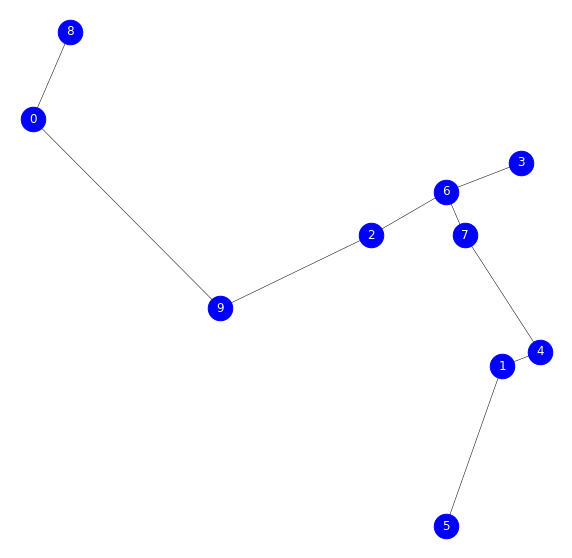

In [ ]:
plt.figure(figsize=args.figsize)


pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

nx.draw_networkx(T, 
                 pos=pos, 
                 width=0.5, 
                 node_shape='o', 
                 node_size=600,
                 node_color='blue')

nx.draw_networkx_labels(T, pos=pos, font_color='w', font_size=12);

  
plt.axis('off')
plt.show()

In [ ]:
root = 0

args.figsize=(20,15)

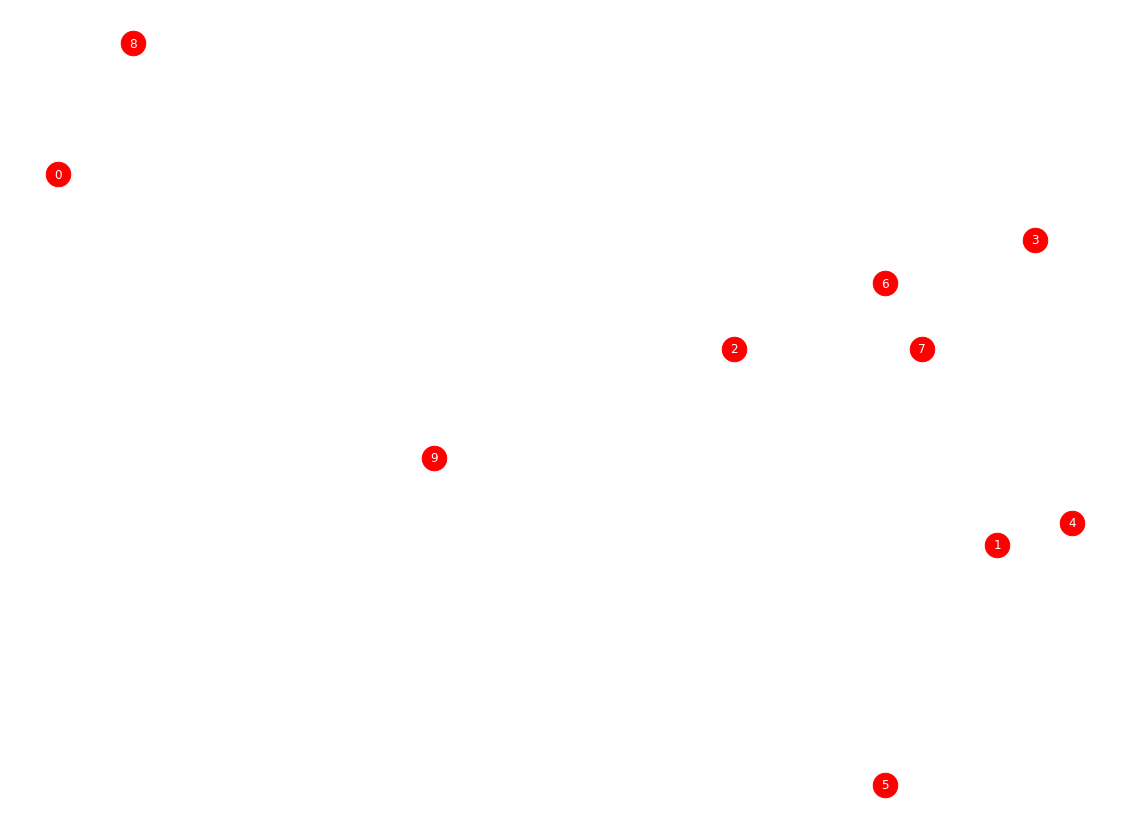

In [ ]:
DrawInitG(G)

# Define a Directed Graph by doubling the edges of G

D = G.to_directed()

In [ ]:
mstflow = gb.Model()

In [ ]:
x = mstflow.addVars(G.edges(), obj=[G[u][v]['cost'] for u,v in G.edges()],\
                    ub = 1.0,\
                    vtype=gb.GRB.BINARY,\
                    name='x')

f = mstflow.addVars(D.edges(), ub=G.number_of_nodes(), vtype=gb.GRB.CONTINUOUS, name='f')



In [ ]:
mstflow.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mstflow.update()

In [ ]:
mstflow.addConstr(f.sum(root, '*') - f.sum('*', root) == G.number_of_nodes() - 1, \
                  'Flow_at_root')

mstflow.update()

In [ ]:
#
# Root is the first nodes
# The iterator moves one step ahead
#


for v in G.nodes():
    if v != root:
        name = 'Balance_' + str(v)
        mstflow.addConstr(f.sum('*',v) - f.sum(v,'*') == 1, name=name)
    
mstflow.update()



In [ ]:
for e in G.edges():
    
    h = e[0]
    k = e[1]
        
    name = "Force_f(%d,%d)_x(%d,%d)" % (h, k, e[0], e[1])
    mstflow.addConstr(f[h,k] <= (G.number_of_nodes() - 1) * x[e], name=name)

    name = "Force_f(%d,%d)_x(%d,%d)" % (k, h, e[0], e[1])
    mstflow.addConstr(f[k,h] <= (G.number_of_nodes() - 1) * x[e], name=name)

mstflow.update()
mstflow.write('mstflow.lp')

In [ ]:
mstflow.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 101 rows, 135 columns and 405 nonzeros
Model fingerprint: 0x6d097c73
Variable types: 90 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 14550.000000
Presolve time: 0.01s
Presolved: 101 rows, 135 columns, 405 nonzeros
Variable types: 90 continuous, 45 integer (45 binary)

Root relaxation: objective 5.746667e+03, 57 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5746.66667    0    5 14550.0000 5746.66667  60.5%     -    0s
H    0     0                    7002.0000000 5746.66667  17.9%     -    0s
     0     0 6507.000

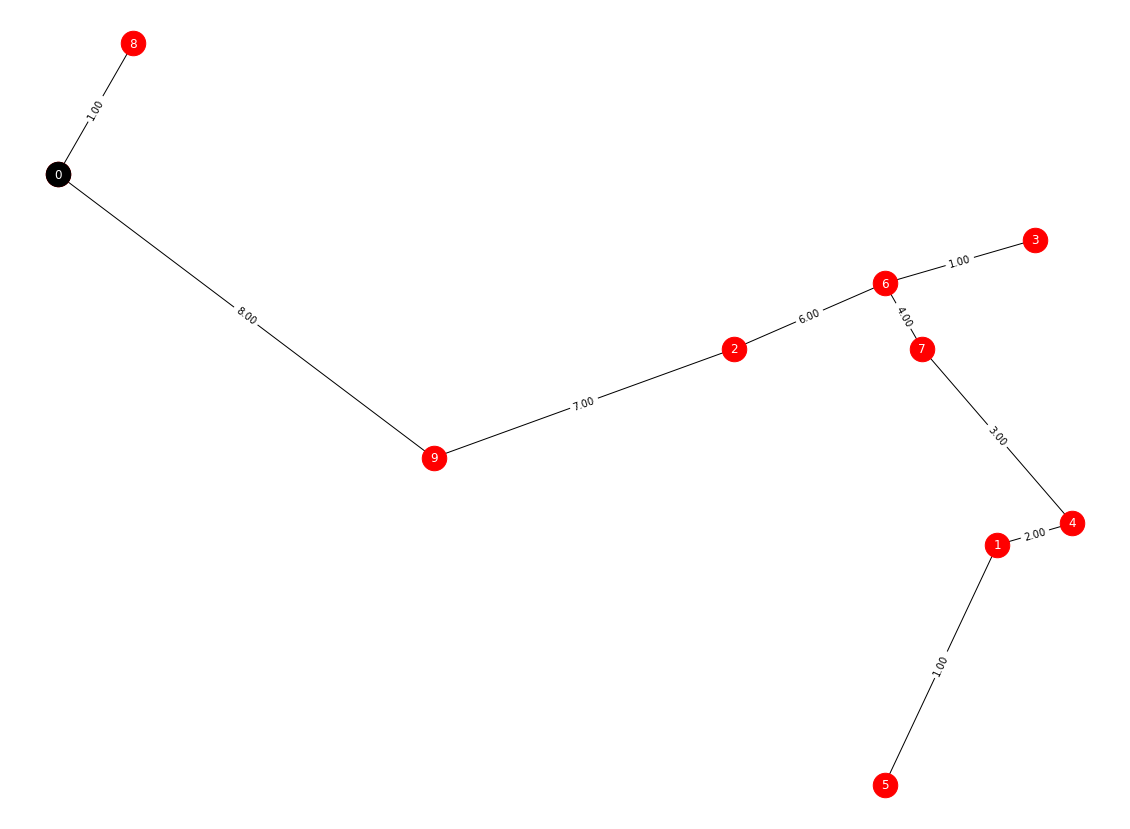

In [ ]:
DrawSolFlow(G, x, f)



## Degree constrained spanning tree

$$ \sum_{e \in \delta(0)} x_e \le \Delta$$ 

In [ ]:
rootdeg = 5

mstflow.addConstr(gb.quicksum([x[e] for e in G.edges(root)]), \
                  sense='<=', rhs=rootdeg, name='RootDegree')

mstflow.update()


mstflow.write('mst_deg.lp')

In [ ]:
mstflow.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 102 rows, 135 columns and 414 nonzeros
Model fingerprint: 0x689ea2b7
Variable types: 90 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]

MIP start from previous solve produced solution with objective 6735 (0.01s)
Loaded MIP start from previous solve with objective 6735

Presolve time: 0.00s
Presolved: 102 rows, 135 columns, 414 nonzeros
Variable types: 90 continuous, 45 integer (45 binary)

Root relaxation: objective 5.746667e+03, 72 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 5746.66667    0    5 6735.00000 5746.66667  14.7%     -    0s
     0    

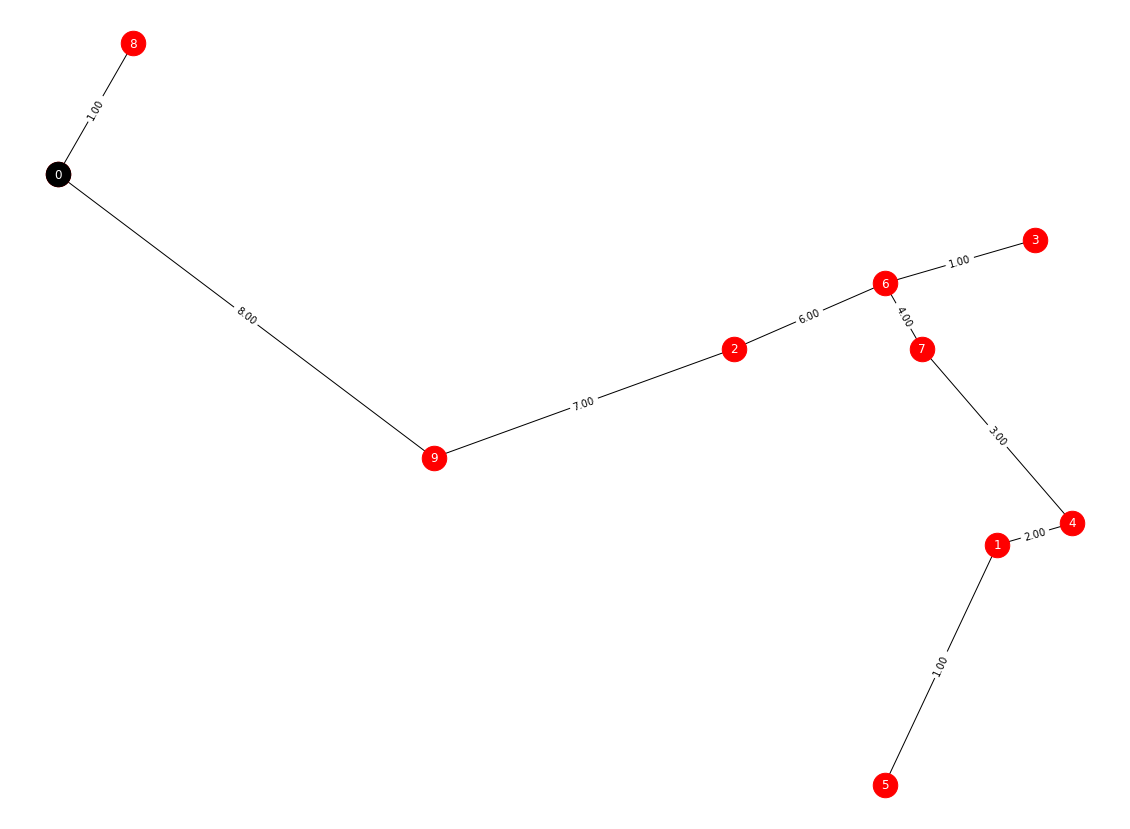

In [ ]:
DrawSolFlow(G, x, f)


The next statement remove the ``RootDegree`` constraint

In [ ]:
mstflow.remove(mstflow.getConstrByName('RootDegree'))

mstflow.update()

mstflow.write('mst_deg.lp')

## Capacitated spanning tree

In [ ]:
subtreecap = 7

for i in f:
    f[i].ub = subtreecap

In [ ]:
mstflow.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 101 rows, 135 columns and 405 nonzeros
Model fingerprint: 0x08ab1a9a
Variable types: 90 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 9e+00]

MIP start from previous solve did not produce a new incumbent solution

Presolve time: 0.00s
Presolved: 101 rows, 135 columns, 405 nonzeros
Variable types: 90 continuous, 45 integer (45 binary)
Found heuristic solution: objective 21270.000000

Root relaxation: objective 6.115429e+03, 62 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6115.42857    0    5 21270.0000 6115.42857  71.2%     -    0s
H    0     0           

In [ ]:
mstflow.write('mst_deg.lp')

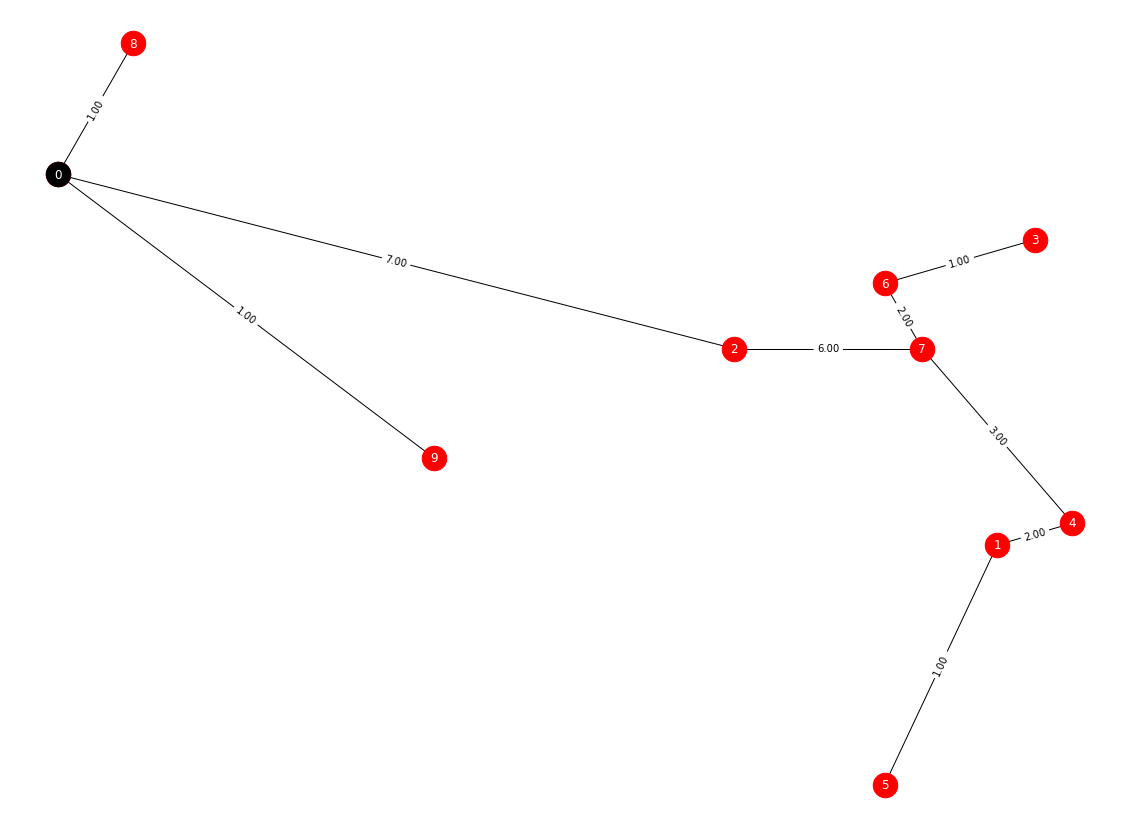

In [ ]:
DrawSolFlow(G, x, f)
